# Exploring the data collected by HealthKit

### Exporting the data
In the Health App hit your profile, then the "Export all Health Data" button. AirDrop the zip to your computer in a directory you can use then unzip using `unzip export.zip`

In [1]:
!tree apple_health_export
# !pip install bokeh

apple_health_export
├── export.xml
├── export_cda.xml
└── workout-routes
    ├── route_2019-08-13_11.27am.gpx
    ├── route_2019-08-18_9.35am.gpx
    ├── route_2019-08-26_4.05pm.gpx
    ├── route_2019-09-04_3.57pm.gpx
    ├── route_2019-09-08_1.47pm.gpx
    ├── route_2019-09-11_4.37pm.gpx
    ├── route_2019-09-16_4.44pm.gpx
    ├── route_2019-09-23_10.32am.gpx
    ├── route_2019-09-23_3.38pm.gpx
    └── route_2019-10-29_5.09pm.gpx

1 directory, 12 files


In [2]:
import pandas as pd
import xmltodict
import json
import pickle

In [3]:
def read_file(name):
    with open(name) as f:
        contents = f.read()
    
    xml = xmltodict.parse(contents)
    return xml

health = read_file("apple_health_export/export.xml")
clinical = read_file("apple_health_export/export_cda.xml")

In [4]:
# for k in health["HealthData"].keys():
#     print(k)

# ActivitySummary

In [5]:
def parse_file(xml):
    health_data = xml["HealthData"]
    for key in health_data.keys():
        with open(f"pkl/{str(key)}.pkl", 'wb') as f:
            pickle.dump(health_data[key], f)
    

parse_file(health)
# parse_file(clinical)

In [29]:
def flatten_nested(df, nested):
    df = df.copy()
    meta = pd.DataFrame()
    
    for i, array in enumerate(df[nested].values):
        d = {}
        if type(array) is list:
            for ord_dict in array:
                d[ord_dict['@key']] = ord_dict['@value']
        elif type(array) is float:
            d[''] = ''
        else:
            # contains only key and value
            d[array['@key']] = array['@value']

        meta = meta.append(d, ignore_index=True)
    return pd.concat([df, meta], axis=1)

def convertColumn(name, col):
    if "date" in name.lower():
        # I can't find any documentation on the "-1000" so I am just removing it :)
        return col.str.strip("-1000").astype("datetime64[ns]")

    return pd.to_numeric(col, errors='ignore')

def data_cleaning(dataframe, nested_column):
    dataframe = flatten_nested(dataframe, nested_column)
    for c in dataframe:
        dataframe[c] = convertColumn(c, dataframe[c])
    dataframe.columns = dataframe.columns.str.replace('@','')
    return dataframe


In [82]:
with open("pkl/Workout.pkl", 'rb') as f:
    Workout = pd.DataFrame(pickle.load(f))
    workout_df = data_cleaning(Workout, 'MetadataEntry')
    
    # Oi looks like we have an outlier (forgot to stop a workout recording for 20hours)
    workout_df = workout_df.drop(162)

In [32]:
with open("pkl/ActivitySummary.pkl", 'rb') as f:
    Activity = pd.DataFrame(pickle.load(f))
    # this data set doesn't need much cleaning :)
    Activity.columns = Activity.columns.str.replace('@','')
    activity_df = Activity

In [44]:
with open("pkl/Record.pkl", 'rb') as f:
    Record = pd.DataFrame(pickle.load(f))
    # this times out. Need to think of another way to clean this dataset!
    #  record_df = data_cleaning(Record, 'MetadataEntry')

In [46]:
# record_df = data_cleaning(Record, 'MetadataEntry')
record_df[record_df.HeartRateVariabilityMetadataList.notnull()]

,type,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value,device,MetadataEntry,HeartRateVariabilityMetadataList,,HKMetadataKeyHeartRateMotionContext


In [ ]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

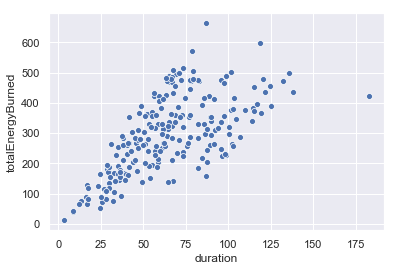

In [84]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

ax = sns.scatterplot(x="duration", y="totalEnergyBurned", data=workout_df)

In [50]:
import bokeh


In [164]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mplcolors

output_notebook()

TOOLTIPS = [
    ('index', "$index"),
    ("x", "$x"),
    ("y", "$y"),
    ("workoutActivityType", "@w")
]
def colors_from_categories(categories):
    colors = [
        "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*cm.viridis(mplcolors.Normalize()(range(0,10)))
    ]
    
    d = {}
    for i, c in enumerate(categories):
        d[c] = colors[i]
    return d

color_dict = colors_from_categories(workout_df.workoutActivityType.unique())
color = [color_dict[x] for x in workout_df.workoutActivityType]

print(colors, colormap)

def pretty_graph(df, x, y, x_label, y_label, title):
        w = workout_df.workoutActivityType
        p = figure(
            plot_width=400, plot_height=400, 
            x_axis_label=x_label,
            y_axis_label=y_label,
            title=title,
            tools='hover,wheel_zoom', 
            tooltips=TOOLTIPS
        )

        # add a circle renderer with a size, color, and alpha
        p.circle(df[x], df[y], size=10, 
                 color=color, alpha=0.5
                 #, legend_field=df.workoutActivityType.uniqu
                )
    
        return p


# show the results

p = pretty_graph(workout_df, "duration", "totalEnergyBurned", 'Duration', "Calories Burned", "Duration of exercise correlated versus calories burned?")

p.xgrid.grid_line_color = None
# p.legend.orientation = "horizontal"
# p.legend.location = "top_center"

show(p)

Loading BokehJS ...

['#440154', '#472777', '#3e4989', '#30678d', '#25828e', '#1e9d88', '#35b778', '#6dce58', '#b5dd2b', '#fde724'] {'HKWorkoutActivityTypeYoga': '#440154', 'HKWorkoutActivityTypeRunning': '#472777', 'HKWorkoutActivityTypeCycling': '#3e4989', 'HKWorkoutActivityTypeFunctionalStrengthTraining': '#30678d', 'HKWorkoutActivityTypeStairClimbing': '#25828e', 'HKWorkoutActivityTypeDance': '#1e9d88', 'HKWorkoutActivityTypeOther': '#35b778', 'HKWorkoutActivityTypeWalking': '#6dce58', 'HKWorkoutActivityTypeHighIntensityIntervalTraining': '#b5dd2b'}


In [109]:
# !pip install itertools
import itertools

In [98]:
workout_df.head()

,workoutActivityType,duration,durationUnit,totalDistance,totalDistanceUnit,totalEnergyBurned,totalEnergyBurnedUnit,sourceName,sourceVersion,device,...,endDate,MetadataEntry,WorkoutEvent,WorkoutRoute,HKIndoorWorkout,HKTimeZone,HKWeatherHumidity,HKWeatherTemperature,HKElevationAscended,HKAverageMETs
0,HKWorkoutActivityTypeYoga,86.734807,min,0.000000,mi,158.250412,kcal,Cassandra’s Apple Watch,5.0.1,"<<HKDevice: 0x281031ea0>, name:Apple Watch, ma...",...,2018-11-21 10:47:15,"[{'@key': 'HKTimeZone', '@value': 'Pacific/Hon...","[{'@type': 'HKWorkoutEventTypePause', '@date':...",NaN,0,Pacific/Honolulu,64 %,78 degF,NaN,NaN
1,HKWorkoutActivityTypeYoga,96.043219,min,0.000000,mi,337.236766,kcal,Cassandra’s Apple Watch,5.0.1,"<<HKDevice: 0x281032350>, name:Apple Watch, ma...",...,2018-11-23 08:31:59,"[{'@key': 'HKTimeZone', '@value': 'America/Los...","[{'@type': 'HKWorkoutEventTypePause', '@date':...",NaN,0,America/Los_Angeles,100 %,55 degF,NaN,NaN
2,HKWorkoutActivityTypeYoga,67.638899,min,0.000000,mi,141.455198,kcal,Cassandra’s Apple Watch,5.0.1,"<<HKDevice: 0x281032800>, name:Apple Watch, ma...",...,2018-11-24 08:01:27,"[{'@key': 'HKTimeZone', '@value': 'America/Los...","[{'@type': 'HKWorkoutEventTypePause', '@date':...",NaN,0,America/Los_Angeles,88 %,59 degF,NaN,NaN
3,HKWorkoutActivityTypeYoga,84.618622,min,0.000000,mi,218.671094,kcal,Cassandra’s Apple Watch,5.0.1,"<<HKDevice: 0x281032cb0>, name:Apple Watch, ma...",...,2018-11-25 08:56:48,"[{'@key': 'HKTimeZone', '@value': 'America/Los...",NaN,NaN,0,America/Los_Angeles,76 %,57 degF,NaN,NaN
4,HKWorkoutActivityTypeRunning,69.064064,min,5.324108,mi,494.048581,kcal,Cassandra’s Apple Watch,5.0.1,"<<HKDevice: 0x281033160>, name:Apple Watch, ma...",...,2018-11-27 06:08:35,"[{'@key': 'HKIndoorWorkout', '@value': '0'}, {...","[{'@type': 'HKWorkoutEventTypeSegment', '@date...",NaN,0,America/Los_Angeles,90 %,51 degF,10999 cm,NaN
